In [8]:
! pip install -q kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandeshprasadpaudel","key":"74d1fc40a1c6a15f2766cf2b4e79b5f7"}'}

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                          title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hummaamqaasim/jobs-in-data                                   Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32           2626         51  1.0              
thedrcat/daigt-v2-train-dataset                              DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           3563        286  1.0              
marouandaghmoumi/dropout-and-success-student-data-analysis   Dropout and Success: Student Data Analysis   87KB  2023-12-31 15:44:56           1720         48  1.0              
mmohaiminulislam/ecommerce-data-analysis                     ECommerce Data Analysis                      17MB  202

In [12]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:16<00:00, 197MB/s]
100% 2.29G/2.29G [00:16<00:00, 152MB/s]


In [13]:
! ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [14]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from tensorflow import keras
import sklearn

In [3]:
train_normal = glob.glob('/content/chest_xray/train/NORMAL/*jpeg')
test_normal = glob.glob('/content/chest_xray/test/NORMAL/*jpeg')
val_normal = glob.glob('/content/chest_xray/val/NORMAL/*jpeg')
train_pneu = glob.glob('/content/chest_xray/train/PNEUMONIA/*jpeg')
test_pneu = glob.glob('/content/chest_xray/test/PNEUMONIA/*jpeg')
val_pneu = glob.glob('/content/chest_xray/val/PNEUMONIA/*jpeg')

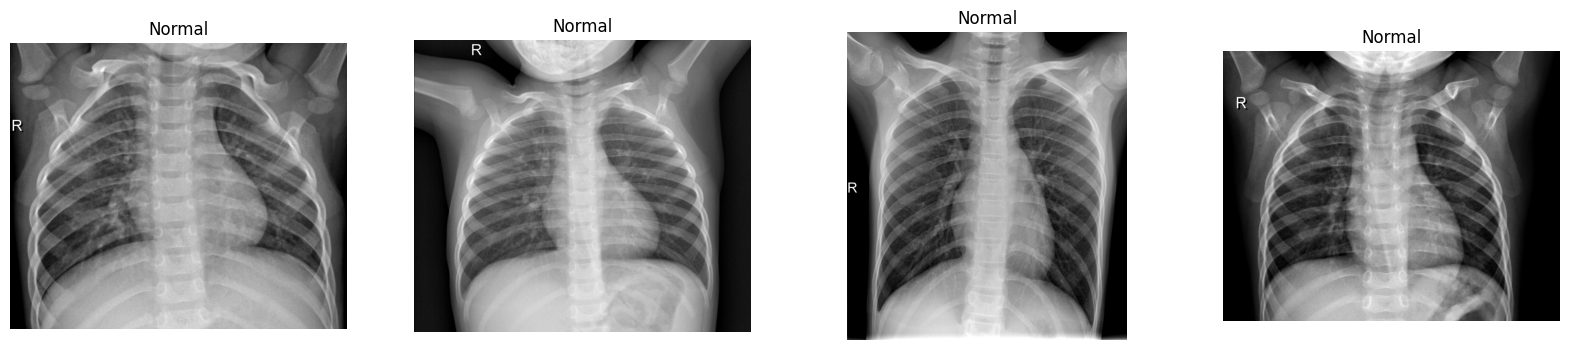

In [17]:
plt.figure(figsize=(20,4))
for i in enumerate(train_normal[0:4]):
    plt.subplot(1,4,i[0]+1)
    plt.axis('off')
    image = plt.imread(i[1])
    plt.imshow(image, cmap='gray')
    plt.title('Normal')

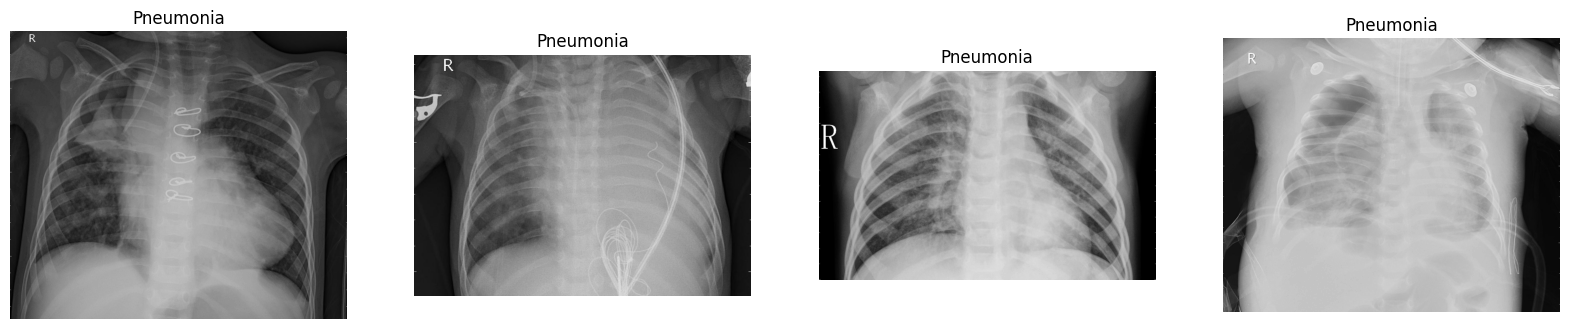

In [18]:
plt.figure(figsize=(20,4))
for i in enumerate(train_pneu[0:4]):
    plt.subplot(1,4,i[0]+1)
    plt.axis('off')
    image = plt.imread(i[1])
    plt.imshow(image, cmap='gray')
    plt.title('Pneumonia')

In [19]:
img = plt.imread(train_pneu[0])
type(img)

numpy.ndarray

In [20]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
img.shape

(224, 224, 3)

In [21]:
train_normal[0:4]

['/content/chest_xray/train/NORMAL/IM-0727-0001.jpeg',
 '/content/chest_xray/train/NORMAL/IM-0243-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-1024-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-1002-0001.jpeg']

In [4]:
# def generateXandY(normal, pneumonia):
#     X = []
#     Y = []
#     for i in normal:
#         img = plt.imread(i)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (224,224))
#         img = img/255.0
#         X.append(img)
#         Y.append(0)
#     for i in pneumonia:
#         img = plt.imread(i)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (224,224))
#         img = img/255.0
#         X.append(img)
#         Y.append(1)
#     shuffledX, shuffledY = sklearn.utils.shuffle(np.array(X), np.array(Y))
#     return shuffledX, shuffledY
def generateXandY(labelType, data):
    X = []
    Y = []
    for i in data:
        img = plt.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        img = img/255.0
        X.append(img)
        if labelType=='normal':
            Y.append(0)
        else:
            Y.append(1)
    return np.array(X), np.array(Y)

In [5]:
train_normal_X, train_normal_Y = generateXandY('normal', train_normal)
# test_X, test_Y = generateXandY(test_normal, test_pneu)
# val_X, val_Y = generateXandY(val_normal, val_pneu)

In [6]:
train_pneu_X, train_pneu_Y = generateXandY('pneu', train_pneu)

In [ ]:
train_X_unshuffled = np.concatenate((train_normal_X, train_pneu_X), axis=0)
train_Y_unshuffled = np.concatenate((train_normal_Y, train_pneu_Y), axis=0)
train_X, train_Y = sklearn.utils.shuffle(train_X_unshuffled, train_Y_unshuffled)

In [7]:
train_X.shape

(0,)